# Submit Your Early Assignment

Complete the assignment by following the steps outlined below. Save and submit your work as an ipynb file when finished. You are expected to complete this assignment in under one hour.



## Step 0: Download the Image from the Given URL, setting up Notebooks
Retrieve the image from this link: [The Mysterious Painting](https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg)

Next, go through each of the three provided notebooks. Combine them into a new notebook and configure your environment according to the specifications for the tasks below.


In [1]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

%cd {HOME}

!mkdir {HOME}/data
%cd {HOME}/data

!wget -q https://upload.wikimedia.org/wikipedia/en/7/74/PicassoGuernica.jpg

%cd {HOME}

!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

HOME: /home/unav/Desktop/Computer_Vision_Homework/Assignment0/submission
/home/unav/Desktop/Computer_Vision_Homework/Assignment0/submission
/home/unav/Desktop/Computer_Vision_Homework/Assignment0/submission/data
/home/unav/Desktop/Computer_Vision_Homework/Assignment0/submission
/home/unav/Desktop/Computer_Vision_Homework/Assignment0/submission/weights



## Step 1: Artist Recognition with the SigLip Model
Utilize the SigLIP model(CLIP with Sigmoid activation) to identify the artist of the painting from the list of artists provided below. Display the prediction accuracy. The expected output is the artist's name, denoted as [ARTIST].

Use the following Possible Artist Descriptions for zero-shot classification:
```python
descriptions = [
  "a painting by Leonardo da Vinci",
  "a painting by Michelangelo",
  "a painting by Vincent van Gogh",
  "a painting by Pablo Picasso",
  "a painting by Rembrandt",
  "a painting by Claude Monet"
]
```


In [2]:
from transformers import AutoProcessor, AutoModel
from PIL import Image
import torch
from os.path import join

# Load the SigLIP model and processor
processor = AutoProcessor.from_pretrained("google/siglip-so400m-patch14-384")
model = AutoModel.from_pretrained("google/siglip-so400m-patch14-384")

# Load the image
image = Image.open(join(HOME, 'data','PicassoGuernica.jpg')).convert("RGB")

# Define the artist descriptions
descriptions = [
    "a painting by Leonardo da Vinci",
    "a painting by Michelangelo",
    "a painting by Vincent van Gogh",
    "a painting by Pablo Picasso",
    "a painting by Rembrandt",
    "a painting by Claude Monet"
]

# Prepare inputs
inputs = processor(text=descriptions, images=image, return_tensors="pt", padding=True)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Calculate probabilities
logits_per_image = outputs.logits_per_image
probs = torch.sigmoid(logits_per_image)

# Output the result
for i, prob in enumerate(probs[0].cpu().numpy()):
    print(f"{descriptions[i]}: {prob * 100:.2f}%")


a painting by Leonardo da Vinci: 0.04%
a painting by Michelangelo: 0.04%
a painting by Vincent van Gogh: 0.01%
a painting by Pablo Picasso: 97.28%
a painting by Rembrandt: 0.02%
a painting by Claude Monet: 0.00%



## Step 2: Style-Based Object or Scene Generation
Once you've identified the [ARTIST], use this information to run the Stable Diffusion model. Create an object or scene (of your choice) inspired by the style of the identified artist. The output for this step should be an image, labeled as [GEN_IMAGE].


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

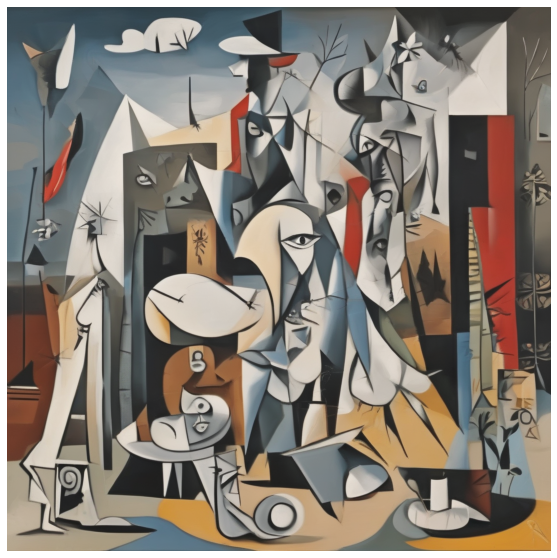

In [3]:
from diffusers import StableDiffusionXLPipeline
import torch
import matplotlib.pyplot as plt

# Load Stable Diffusion XL model
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

# Generate image based on the identified artist's style
prompt = "a surreal scene in the style of Pablo Picasso"
GEN_IMAGE = pipe(prompt).images[0]

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(GEN_IMAGE)
plt.axis("off")
plt.show()

GEN_IMAGE.save(join(HOME, 'data','PicassoSurreal.jpg'))


## Step 3: Image Segmentation with SAM Model
Take the generated image [GEN_IMAGE] from the previous step, and apply the SAM model for image segmentation. Present the segmentation masks. The result of this task should be a segmented image, denoted as [SEGMENT]. If you face issues such as CUDA running out of memory during SAM step, try to resize the image to a smaller scale before SAM.


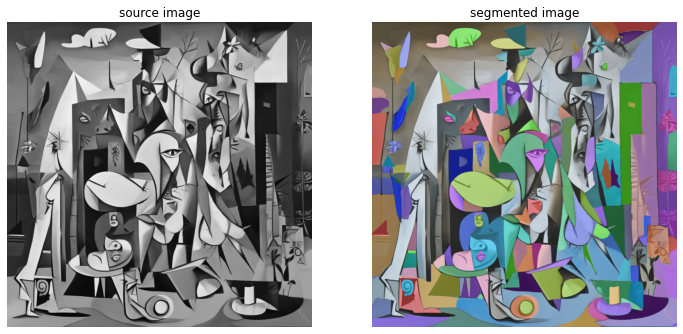

In [4]:
import cv2
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import torch
import supervision as sv
import numpy as np

# Load the SAM model on cuda:1
sam = sam_model_registry["vit_h"](checkpoint=join(HOME,"weights", "sam_vit_h_4b8939.pth")).to(torch.device("cuda:1"))
mask_generator = SamAutomaticMaskGenerator(sam)

# Convert PIL image to a numpy array
image_np = np.array(GEN_IMAGE)

# Generate masks
sam_result = mask_generator.generate(image_np)

# Annotate the masks and visualize
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)

# Annotating the scene with the detected masks
SEGMENT = mask_annotator.annotate(scene=image_np.copy(), detections=detections)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

# Displaying the original and segmented images side by side
sv.plot_images_grid(
    images=[gray_image, SEGMENT],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)
